<a href="https://colab.research.google.com/github/alifele/EEG-computation/blob/master/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Important Imports

In [1]:
!pip install mat4py
import numpy as np
import matplotlib.pyplot as plt
import mat4py as mt
import os
from IPython.display import Image
from IPython.core.display import HTML 
from itertools import combinations
from numpy.fft import fft
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA
from numpy.fft import fft

# Loading Data

In [2]:
!git clone https://github.com/alifele/EEG-computation.git
%cd EEG-computation

Cloning into 'EEG-computation'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (428/428), done.
remote: Compressing objects: 100% (423/423), done.
remote: Total 428 (delta 41), reused 351 (delta 2), pack-reused 0
Receiving objects: 100% (428/428), 582.71 MiB | 55.22 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Checking out files: 100% (347/347), done.
/content/EEG-computation


In [0]:
disorder_dic = []
directory = os.fsencode('EEG Data/disorder')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    disorder_dic.append(np.array(mt.loadmat('EEG Data/disorder/{}'.format(filename))[filename.split('.')[0]]))
    
channels_disorder = [ [] for i in range(len(disorder_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_disorder:
    for i in range(19):
        person.append(disorder_dic[j][:,i])
    j = j+1
        
normal_dic = []
directory = os.fsencode('EEG Data/normal')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    normal_dic.append(np.array(mt.loadmat('EEG Data/normal/{}'.format(filename))[filename.split('.')[0]]))
    
channels_normal = [ [] for i in range(len(normal_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_normal:
    for i in range(19):
        person.append(normal_dic[j][:,i])
    j = j+1   
        
data = {"N":channels_normal,
      "D":channels_disorder}


# Generating New Data

In [0]:
def New_Data_Generator_N():
    number_of_samples = 30
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['N'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['N'].append(new_data[person])
        person += 1

    
def New_Data_Generator_D():
    number_of_samples = 30
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['D'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['D'].append(new_data[person])
        person += 1


In [0]:
New_Data_Generator_N()
New_Data_Generator_D()

In [6]:
n_D , n_N = len(data['D']), len(data['N'])

print('The number of Disorders is:{} and the number of Normals is:{}'.format(n_D, n_N))

The number of Disorders is:631 and the number of Normals is:567


# Generating The FT Data set

In [0]:
def Clear_FDomain():
  index = np.arange(0,512*30)
  f = np.linspace(0,512,512*30)
  f_max = f[len(f[f<120])]
  ind_min = 2
  ind_max = list(index[f==f_max])[0]
  f_min = f[ind_min]

  print('The f_min is {}\nThe f_max is {}\nThe ind_min is {} \nAnd the ind_max is {}'.format(f_min, f_max, ind_min, ind_max))


  sam_FT = np.abs(np.fft.fft(data['D'][50][7]))

  # The 50 Htz noise elimination information

  f_45 = f>45
  f_55 = f<55
  f_bar = f<45

  for i in range(f.shape[0]):
    f_bar[i] = f_45[i] and f_55[i]


  noise = f[sam_FT == np.max(sam_FT[f_bar])][0]
  noise_index = list(index[f==noise])[0] # in range 0, 512*30
  del_domain = 40
  del_range = [noise_index + i for i in range(-del_domain,del_domain)]
  print('The Frequency of noise is:{} and the index of the noise is:{}'.format(noise, noise_index))

  
  plt.figure()
  plt.plot(f_bar)
  f = np.linspace(0,512,512*30)[ind_min:ind_max]
  
  
  normal = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_N)]
  disorder = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_D)]


  FT = {'D':disorder,
       'N':normal}

  from numpy.fft import fft

  for d in range(n_D):
      for i in range(19):

          FT['D'][d][i] = np.abs(fft(data['D'][d][i]))[ind_min:ind_max]
          FT['D'][d][i][noise_index-del_domain  - ind_min: noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][noise_index-del_domain  - ind_min - 120: noise_index+del_domain - ind_min-120])
          FT['D'][d][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][2*noise_index-del_domain - ind_min - 120: 2*noise_index+del_domain - ind_min-120])

  for n in range(n_N):
      for i in range(19):
          FT['N'][n][i] = np.abs(fft(data['N'][n][i]))[ind_min:ind_max]
          FT['N'][n][i][noise_index-del_domain - ind_min: noise_index+del_domain -ind_min] = np.average(FT['N'][n][i][noise_index-del_domain - ind_min-120: noise_index+del_domain -ind_min-120])
          FT['N'][n][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average( FT['N'][n][i][2*noise_index-del_domain - ind_min-120 : 2*noise_index+del_domain - ind_min-120])


      FT['N'] = np.array(FT['N'])
      FT['D'] = np.array(FT['D'])
  plt.figure()
  plt.plot(f, FT['N'][56][8])
  
  
  

  FT_matrix_N = FT['N']
  FT_matrix_D = FT['D']

  temp_D = FT_matrix_D.reshape((FT_matrix_D.shape[0],FT_matrix_D.shape[2],FT_matrix_D.shape[1]))
  temp_N = FT_matrix_N.reshape((FT_matrix_N.shape[0],FT_matrix_N.shape[2],FT_matrix_N.shape[1]))
  #or d in range(FT_matrix.shape[0]):
  scaler = StandardScaler()

  for n in range(FT_matrix_N.shape[0]):
    temp_N[n]= scaler.fit_transform(FT_matrix_N[n].T)
  
  for d in range(FT_matrix_D.shape[0]):
    temp_D[d]= scaler.fit_transform(FT_matrix_D[d].T)

    
  for n in range(FT_matrix_N.shape[0]):
    FT_matrix_N[n]= temp_N[n].T
  
  for d in range(FT_matrix_D.shape[0]):
    FT_matrix_D[d]= temp_D[d].T
    
    
  plt.figure()
  plt.plot(f,FT_matrix_D[56,8])
  FT_matrix_D.shape, FT_matrix_N.shape

  return FT_matrix_D, FT_matrix_N


The f_min is 0.06667100722703301
The f_max is 120.00781300865941
The ind_min is 2 
And the ind_max is 3600
The Frequency of noise is:50.003255420274755 and the index of the noise is:1500


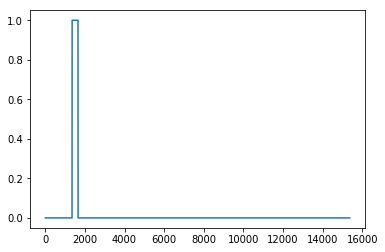

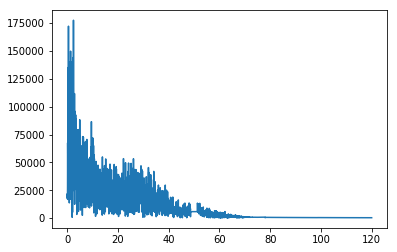

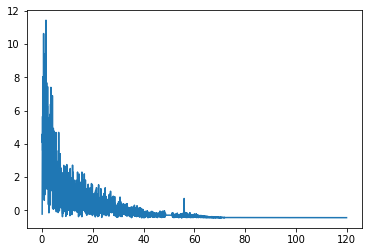

In [11]:
F_D, F_N = Clear_FDomain()

(68362, 1)

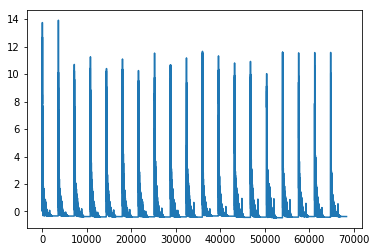

In [20]:
plt.plot(F_D[2].reshape(-1,1))
DF_D[2].reshape(-1,1).shape

# Generating the Time Sequence dataset

In [0]:
def Clear_TDomain():
  T_D = np.array(data['D'])
  T_N = np.array(data['N'])
  temp_D = T_D.reshape((T_D.shape[0],T_D.shape[2],T_D.shape[1]))
  temp_N = T_N.reshape((T_N.shape[0],T_N.shape[2],T_N.shape[1]))
  scaler = StandardScaler()

  for n in range(T_N.shape[0]):
      temp_N[n]= scaler.fit_transform(T_N[n].T)

  for d in range(T_D.shape[0]):
    temp_D[d]= scaler.fit_transform(T_D[d].T)


  for n in range(T_N.shape[0]):
    T_N[n]= temp_N[n].T

  for d in range(T_D.shape[0]):
    T_D[d]= temp_D[d].T

  plt.plot(T_D[3][5])
  
  return T_N, T_D

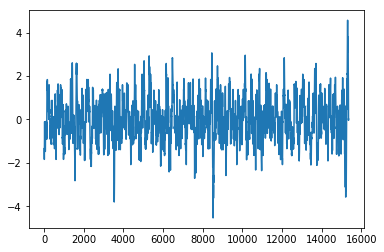

In [40]:
T_N, T_D = Clear_TDomain()

# KNN for the FT Data set

(68362, 1)